### Kaggle competition - Roxane Smadja

# Install packages

In [2]:
library(caret)
library(cattonum)
install.packages("tidyverse")
library(tidyverse)
library(leaps)
library(MASS)
library(pROC)
library(e1071)
library(rpart.plot)

Warning message:
"package 'caret' was built under R version 3.6.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.3"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'cattonum' was built under R version 3.6.3"cattonum is seeking a new maintainer; please respond if interested: https://github.com/bfgray3/cattonum/issues/40


package 'tidyverse' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\rsmadja\AppData\Local\Temp\RtmpKuq4Y7\downloaded_packages


Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages --------------------------------------- tidyverse 1.3.0 --
v tibble  3.0.3     v dplyr   1.0.5
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     
Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()
Warning message:
"package 'leaps' was built under R versi

In [144]:

library(ROCR)

In [3]:
install.packages("dplyr")
library(dplyr)

Warning message:
"package 'dplyr' is in use and will not be installed"

In [4]:
install.packages("caret")
library(caret)

Warning message:
"package 'caret' is in use and will not be installed"

# Load the data

In [5]:
test_file <- read.csv("orange_churn_test.csv",na.strings=c(""))
data_train <- read.csv("orange_churn_train.csv",na.strings=c(""))

In [6]:
#Afficher un graph avec les valeurs manquantes vs les valeurs observées
missmap(data_train, main = "Missing values vs observed")

In [7]:
install.packages("cattonum")

Warning message:
"package 'cattonum' is in use and will not be installed"

In [8]:
library(cattonum)

## Processing Pipeline

In [9]:
processing_pipeline <- function(dataframe){
    #remove columns that are 90% empty
    p_data<- dataframe[,colSums(is.na(dataframe))<9000]
    
    #replace NA by mean for integers and doubles
    for(col in names(p_data)){
        if( typeof(p_data[[col]]) == "integer" | typeof(p_data[[col]]) == "double"){
            p_data[[col]]= ifelse(is.na(p_data[[col]]), ave(p_data[[col]], FUN = function(x) mean(x, na.rm = 'TRUE')), p_data[[col]])
        }
    }
    
    #replace NA in string cols by "Missing" in order for them to be ahdnle by the following function that will replace 
                                                            #categorical variables by their frequency of occurence
    p_data[is.na(p_data)] <- "Missing"
    
    #frequency encoding
    p_data = catto_freq(p_data, verbose=TRUE)
                                                                      
    #remove columns with no variance
    p_data<-p_data[c(TRUE, lapply(p_data[-1], var, na.rm = TRUE) != 0)]

    return(p_data)
}

In [10]:
#apply the preprocessing function to the train set. 
p_data_train <- processing_pipeline(data_train)
p_data_train$churn <- ifelse(p_data_train$churn==1,'yes','no')
labels <- as.factor(p_data_train$churn)
p_data_train$churn <- NULL

Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or lo

In [11]:
#apply the preprocessing function to the test set (dile to be uploaded in kaggle)
p_data_validation <- processing_pipeline(test_file)
p_data_validation <- p_data_validation %>% 
      mutate(
            churn = 0
      )   

Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or logical: returning NA"Warning message in mean.default(x, na.rm = "TRUE"):
"argument is not numeric or lo

## Removing highly correlated features

In [12]:
cor <- cor(p_data_train)
hc <- findCorrelation(cor, cutoff=0.9)
# paste(hc,collapse=", ")

In [18]:
remove_cor <- function(dataset){
    hc <- c(2, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 18, 20, 21, 24, 25, 27, 28, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 45, 46, 47, 49, 50, 51, 52, 53, 54, 57, 58, 59, 60, 61, 62, 66, 68, 70, 71, 72, 74, 75, 76, 77, 78, 80, 82, 83, 85, 86, 87, 89, 90, 91, 93, 94, 96, 97, 98, 100, 101, 104, 105, 106, 107, 109, 110, 111, 112, 114, 117, 119, 120, 121, 123, 125, 126, 127, 129, 131, 134, 135, 137, 139, 140, 141, 142, 143, 144, 146, 147, 148, 150, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 182, 184, 185, 191, 196, 201, 207)
    reduced_data_train = dataset[,-c(hc)]
    return(reduced_data_train)
}

In [19]:
#remove correlation variables of the train set on the test set 
                      #to avoid any difference between the two files, as seen in class,
                         #did exactly the same steps for the train and test set, with a decision made on the train set.
reduced_validation_set <- remove_cor(p_data_validation)

In [20]:
reduced_data_train <- remove_cor(p_data_train)


## Models

In [21]:
#before applying my first model, i splitted the train set into 
                #two part in order to be able to build a confusion matrix and test our model 
                    #and compare to reality 'which is not possible on the test set provided by kaggle 
                            #s the target is not present in it (i splitted by 50%/50%)
reduced_data_train$churn = labels
splitIndex <- createDataPartition(reduced_data_train$churn, p = .5, list = FALSE, times = 1)
trainDF <- reduced_data_train[ splitIndex,]
testDF  <- reduced_data_train[-splitIndex,]

outcomeName <- 'churn'
predictorsNames <- names(trainDF)[names(trainDF) != outcomeName]


In [228]:
write.csv(reduced_data_train, "Basetable_Roxane_Smadja.csv")

# 1. SVM : AUC arround 0.5

In [22]:
#apply a first SVM model linear with cost 0.1
SVMclassifier = svm(formula = churn ~ .,
                 data = trainDF,
                 type = 'C-classification',
                 kernel = 'linear', probability=TRUE, cost=0.1) #can be tweaked : https://www.rdocumentation.org/packages/e1071/versions/1.7-4/topics/svm

In [199]:
pred = predict(SVMclassifier, newdata = testDF, probability=TRUE)
train_pred = predict(SVMclassifier, newdata = trainDF)

In [200]:
Prediction <- prediction(as.numeric(pred), as.numeric(testDF$churn))

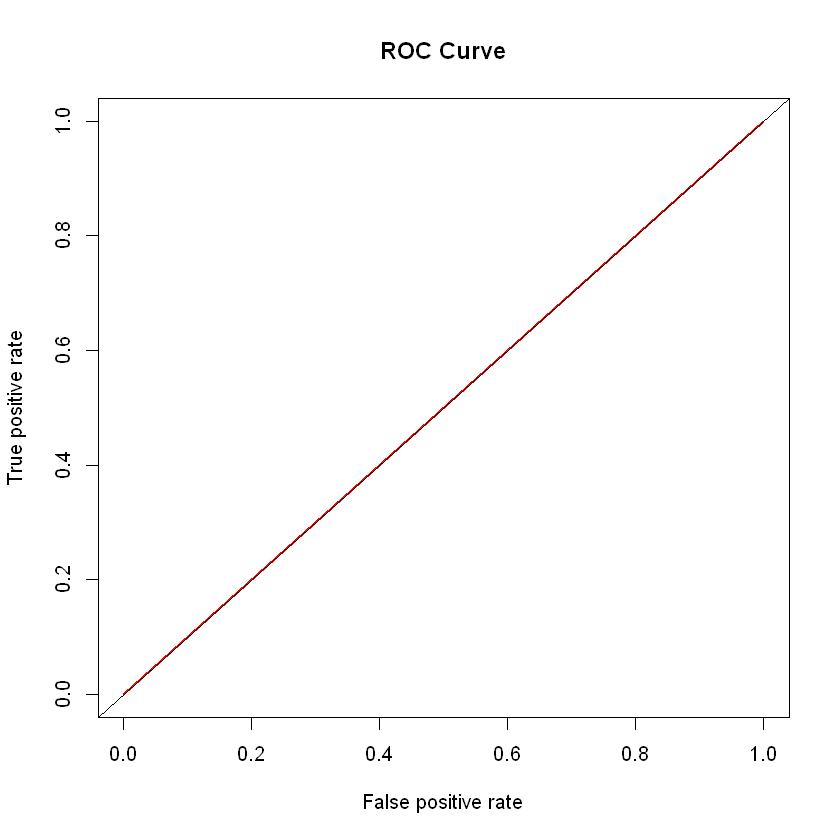

In [209]:
Performance <- performance(Prediction, "tpr","fpr")
# plotting ROC curve
plot(Performance,main = "ROC Curve",col = 2,lwd = 2,  print.auc = TRUE)
abline(a=0, b= 1)


In [24]:
cm = table(testDF$churn, pred)
cm2=table(trainDF$churn, train_pred)
cm2

     train_pred
        no  yes
  no  4632    0
  yes  368    0

We can see here that the model performs badly as all predictions has been predicted as not churn. the speicifity is not enough. 

In [25]:
table(trainDF$churn)


  no  yes 
4632  368 

In [26]:
head(attr(pred, "probabilities"))

,no,yes
3,0.9244529,0.07554706
4,0.9265355,0.07346449
5,0.9269424,0.07305763
8,0.9265645,0.07343552
11,0.9253878,0.07461217
13,0.9251051,0.07489493


In [27]:
pred = predict(SVMclassifier, newdata = reduced_validation_set, probability=TRUE)

In [28]:
pred_svm <- attr(pred, "probabilities")

In [29]:
table <- cbind(reduced_validation_set,pred_svm)

In [30]:
table <- table %>% dplyr::select(cust_id, yes)

In [31]:
write.csv(table , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions3.csv")

In [32]:
SVMclassifier_radial = svm(formula = churn ~ .,
                 data = trainDF,
                 type = 'C-classification',
                 kernel = 'radial', probability=TRUE, gamma=1) #can be tweaked : https://www.rdocumentation.org/packages/e1071/versions/1.7-4/topics/svm

In [197]:
pred_radial = predict(SVMclassifier_radial, newdata = reduced_validation_set, probability=TRUE)

In [34]:
pred_radial <- attr(pred_radial, "probabilities")

In [35]:
table <- cbind(reduced_validation_set,pred_radial)

In [36]:
table <- table %>% dplyr::select(cust_id, yes)

In [37]:
write.csv(table , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions6.csv")

In [38]:
library(e1071)

In [39]:
#perform cross validation to find the best gamma and best cost for a radial kernel SVM
tune.svm = tune(svm, churn ~ ., 
                        data = trainDF, 
                                kernel="radial", 
                                        ranges=list(cost=c(0.1,1,10,100,1000), gamma=c(0.5,1,2,3,4)), 
                                                      tunecontrol = tune.control(sampling = "fix"))

In [40]:
summary(tune.svm)
#the best parameters are indeed 0.1 and 0.5 on the train set


Parameter tuning of 'svm':

- sampling method: fixed training/validation set 

- best parameters:
 cost gamma
  0.1   0.5

- best performance: 0.08158368 

- Detailed performance results:
    cost gamma      error dispersion
1  1e-01   0.5 0.08158368         NA
2  1e+00   0.5 0.08158368         NA
3  1e+01   0.5 0.08158368         NA
4  1e+02   0.5 0.08158368         NA
5  1e+03   0.5 0.08158368         NA
6  1e-01   1.0 0.08158368         NA
7  1e+00   1.0 0.08158368         NA
8  1e+01   1.0 0.08158368         NA
9  1e+02   1.0 0.08158368         NA
10 1e+03   1.0 0.08158368         NA
11 1e-01   2.0 0.08158368         NA
12 1e+00   2.0 0.08158368         NA
13 1e+01   2.0 0.08158368         NA
14 1e+02   2.0 0.08158368         NA
15 1e+03   2.0 0.08158368         NA
16 1e-01   3.0 0.08158368         NA
17 1e+00   3.0 0.08158368         NA
18 1e+01   3.0 0.08158368         NA
19 1e+02   3.0 0.08158368         NA
20 1e+03   3.0 0.08158368         NA
21 1e-01   4.0 0.08158368         

In [41]:
SVMclassifier_radial = svm(formula = churn ~ .,
                 data = trainDF,
                 type = 'C-classification',
                 kernel = 'radial', probability=TRUE, gamma=0.1, cost=0.5) #can be tweaked : https://www.rdocumentation.org/packages/e1071/versions/1.7-4/topics/svm

In [192]:
pred = predict(SVMclassifier_radial, newdata = testDF, probability=TRUE)
train_pred = predict(SVMclassifier_radial, newdata = trainDF)

In [193]:
cm = table(testDF$churn, pred)
cm2=table(trainDF$churn, train_pred)
cm2

     train_pred
        no  yes
  no  4632    0
  yes  368    0

The results are still poor because the algorithm is not able to detect any churner. 

In [194]:
Prediction <- prediction(as.numeric(pred), as.numeric(testDF$churn))

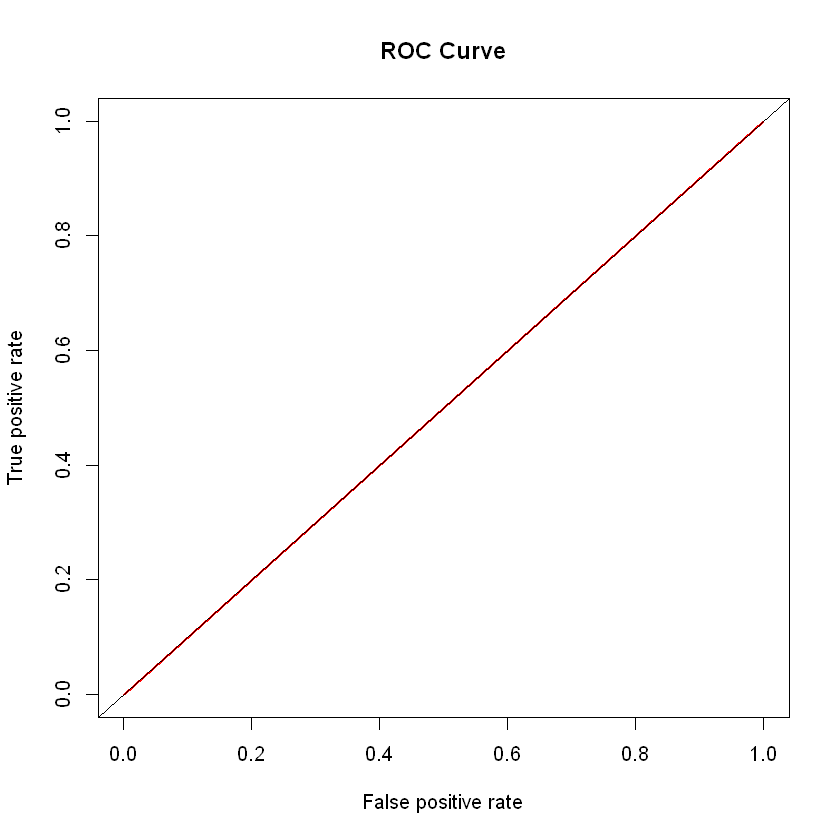

In [195]:
performance <- performance(Prediction, "tpr","fpr")
# plotting ROC curve
plot(performance,main = "ROC Curve",col = 2,lwd = 2,  print.auc = TRUE)
abline(a=0, b= 1)

# 2. Decision Trees: AUC arround 0.5

In [135]:
objControl <- trainControl(method = "repeatedcv", number = 10, repeats = 3)
set.seed(3333)
dtree_fit <- train(churn ~., data = trainDF, method = "rpart",
                   parms = list(split = "information"),
                   trControl=objControl,
                   tuneLength = 10)

In [136]:
dtree_fit

CART 

5000 samples
  78 predictor
   2 classes: 'no', 'yes' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 4501, 4500, 4500, 4500, 4500, 4500, ... 
Resampling results across tuning parameters:

  cp            Accuracy   Kappa     
  0.0004528986  0.8942678  0.08795237
  0.0005434783  0.8942678  0.08708062
  0.0009057971  0.8978680  0.08975542
  0.0009881423  0.8978680  0.08975542
  0.0013586957  0.9018676  0.09426904
  0.0027173913  0.9098668  0.08900630
  0.0031702899  0.9145327  0.07596184
  0.0072463768  0.9256013  0.02298453
  0.0076086957  0.9256015  0.01760885
  0.0081521739  0.9256682  0.01629763

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.008152174.

In [175]:
pred2 = predict(dtree_fit, newdata = testDF)

In [176]:
cm = table(testDF$churn, pred2)
cm2 = table(trainDF$churn, train_pred2)
cm2

     train_pred2
        no  yes
  no  4632    0
  yes  368    0

The decision tree provides interesting result with an accuracy of 0.931; but it could be overfitting as this is quite high: lets test on unseen data

In [183]:
Prediction <- prediction(as.numeric(pred2), as.numeric(testDF$churn))

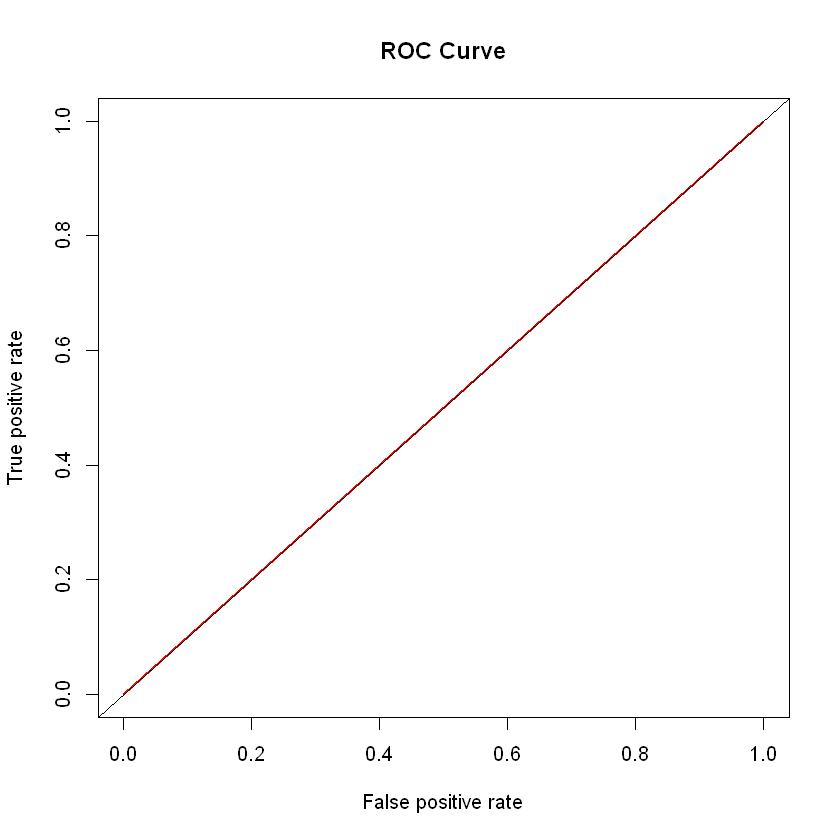

In [191]:
performance <- performance(Prediction, "tpr","fpr")
# plotting ROC curve
plot(performance,main = "ROC Curve",col = 2,lwd = 2,  print.auc = TRUE)
abline(a=0, b= 1)



In [49]:
prob_decision_trees <- predict(dtree_fit, newdata = reduced_validation_set, type="prob")

In [50]:
table_DT <- cbind(reduced_validation_set,prob_decision_trees)

In [51]:
table_DT <- table_DT %>% dplyr::select(cust_id, yes)

In [52]:
write.csv(table_DT , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions4.csv")

# 3. Gradient Boosting: AUC 0.7092

In [53]:
objControl <- trainControl(method='cv', number=3, returnResamp='none', summaryFunction = twoClassSummary, classProbs = TRUE)
gbm <- train(trainDF[,predictorsNames], trainDF[,outcomeName], 
                  method='gbm', 
                  trControl=objControl,  
                  metric = "ROC",
                  preProc = c("center", "scale"))

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        0.5213             nan     0.1000    0.0019
     2        0.5189             nan     0.1000    0.0010
     3        0.5177             nan     0.1000    0.0004
     4        0.5143             nan     0.1000    0.0009
     5        0.5127             nan     0.1000    0.0003
     6        0.5106             nan     0.1000    0.0007
     7        0.5081             nan     0.1000    0.0006
     8        0.5070             nan     0.1000    0.0004
     9        0.5055             nan     0.1000    0.0003
    10        0.5030             nan     0.1000    0.0006
    20        0.4903             nan     0.1000    0.0001
    40        0.4736             nan     0.1000   -0.0001
    60        0.4619             nan     0.1000   -0.0005
    80        0.4539             nan     0.1000   -0.0003
   100        0.4488             nan     0.1000   -0.0001
   120        0.4437             nan     0.1000   -0.0003
   140        

In [54]:
predictions_raw <- predict(object=gbm, testDF[,predictorsNames], type='prob')
#confusionMatrix(predictions_raw,testDF$churn)

In [133]:
predictions_prob <- predict(object=gbm, testDF[,predictorsNames], type='prob')
auc <- roc(ifelse(testDF[,outcomeName]=="yes",1,0), predictions_prob[[2]])
auc$auc

Setting levels: control = 0, case = 1
Setting direction: controls < cases


Area under the curve: 0.7092

In [56]:
predictions1 <- predict(object=gbm, reduced_validation_set[,predictorsNames], type='prob')

In [57]:
table <- cbind(reduced_validation_set,predictions1)

In [58]:
install.packages("Lahman")
library(Lahman)

package 'Lahman' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\rsmadja\AppData\Local\Temp\RtmpKuq4Y7\downloaded_packages


Warning message:
"package 'Lahman' was built under R version 3.6.3"

In [59]:
table1 <- table %>% dplyr::select(cust_id, yes)

In [60]:
write.csv(table1 , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions1.csv")

# 4. Logistic regression and Stepwise analysis to reduce the number of features : AUC : 0.673

In [61]:
# full log model
full.model <- glm(churn ~., data = trainDF, family = binomial)
summary(full.model)


Call:
glm(formula = churn ~ ., family = binomial, data = trainDF)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7141  -0.4229  -0.3103  -0.2106   3.0612  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.025e+01  4.881e+02  -0.062 0.950581    
cust_id     -1.256e-06  9.816e-06  -0.128 0.898194    
Var7        -4.025e-02  3.808e-02  -1.057 0.290539    
Var11       -2.837e-01  6.786e-01  -0.418 0.675942    
Var13       -1.938e-04  1.500e-04  -1.292 0.196266    
Var21        1.822e-04  5.872e-04   0.310 0.756359    
Var24        3.975e-03  4.321e-03   0.920 0.357546    
Var25        1.621e-03  1.268e-03   1.278 0.201076    
Var28       -1.176e-04  1.586e-04  -0.741 0.458542    
Var33       -4.094e-03  1.235e-02  -0.332 0.740209    
Var35        4.955e-02  4.096e-02   1.210 0.226368    
Var44       -8.514e-02  1.500e-01  -0.568 0.570271    
Var45        1.217e-01  1.486e-01   0.819 0.412829    
Var51        1.438e-04  6.096e-04 

In [62]:
# Make predictions
probabilities <- full.model %>% predict(testDF, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "pos", "neg")
# Prediction accuracy
observed.classes <- testDF$churn
mean(predicted.classes == observed.classes)

[1] 0

In [63]:
# stepwise model
step.model <- full.model %>% stepAIC(trace = FALSE)
summary(step.model)


Call:
glm(formula = churn ~ Var13 + Var45 + Var57 + Var65 + Var73 + 
    Var74 + Var78 + Var83 + Var89 + Var102 + Var113 + Var118 + 
    Var126 + Var132 + Var147 + Var181 + Var189 + Var195 + Var196 + 
    Var197 + Var205 + Var210 + Var211 + Var218 + Var219 + Var221, 
    family = binomial, data = trainDF)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6510  -0.4222  -0.3172  -0.2203   3.1151  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.108e+01  4.955e+02  -0.063 0.949989    
Var13       -2.008e-04  1.336e-04  -1.502 0.132978    
Var45        1.152e-01  1.428e-01   0.806 0.420003    
Var57       -5.860e-02  2.804e-02  -2.090 0.036644 *  
Var65        6.216e-02  1.956e-02   3.179 0.001480 ** 
Var73       -5.074e-03  1.554e-03  -3.265 0.001096 ** 
Var74       -1.987e-03  8.472e-04  -2.345 0.019023 *  
Var78        4.314e-02  2.930e-02   1.473 0.140864    
Var83       -5.248e-03  1.913e-03  -2.743 0.006087 ** 
Var89       -

In [130]:
# Make predictions
probabilities <- predict(step.model, testDF, type = "response")
predicted.classes <- ifelse(probabilities > 0.5, "pos", "neg")
# Prediction accuracy
observed.classes <- testDF$churn
mean(predicted.classes == observed.classes)


[1] 0

Setting levels: control = no, case = yes
Setting direction: controls < cases


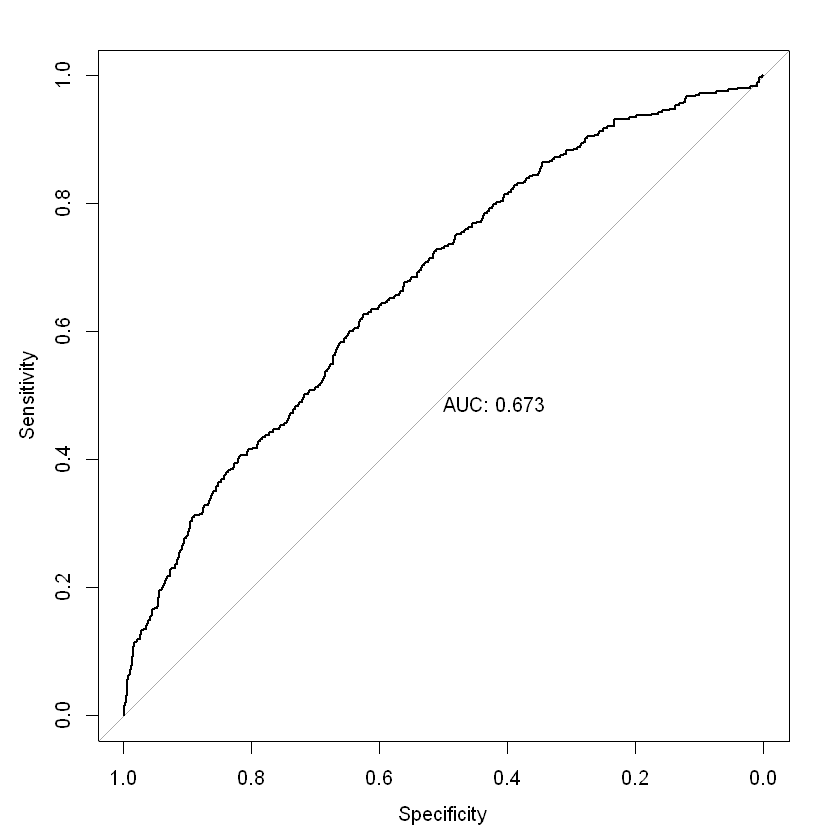

In [131]:
test_roc = roc(testDF$churn ~ probabilities, plot = TRUE, print.auc = TRUE)

In [65]:
cm = table(observed.classes, predicted.classes)

In [66]:
cm

                predicted.classes
observed.classes  neg  pos
             no  4622   10
             yes  360    8

In [127]:
probabilities <- predict(step.model, reduced_validation_set, type = "response")
#predicted.classes <- ifelse(probabilities > 0.5, "pos", "neg")

In [68]:
table2 <- cbind(reduced_validation_set,probabilities)

In [69]:
table2 <- table2 %>% dplyr::select(cust_id, probabilities)

In [70]:
write.csv(table2 , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions2.csv")

# 5. Linear Discriminant Analysis : AUC 0.675

In [216]:
lda.fit <- lda(churn ~., data = trainDF, family = binomial)

In [217]:
probabilities <- predict(lda.fit, testDF)

In [218]:
posterior <- as.data.frame(probabilities$posterior)

In [219]:
library(ROCR)

In [220]:
pred <- prediction(posterior[,2], testDF$churn)

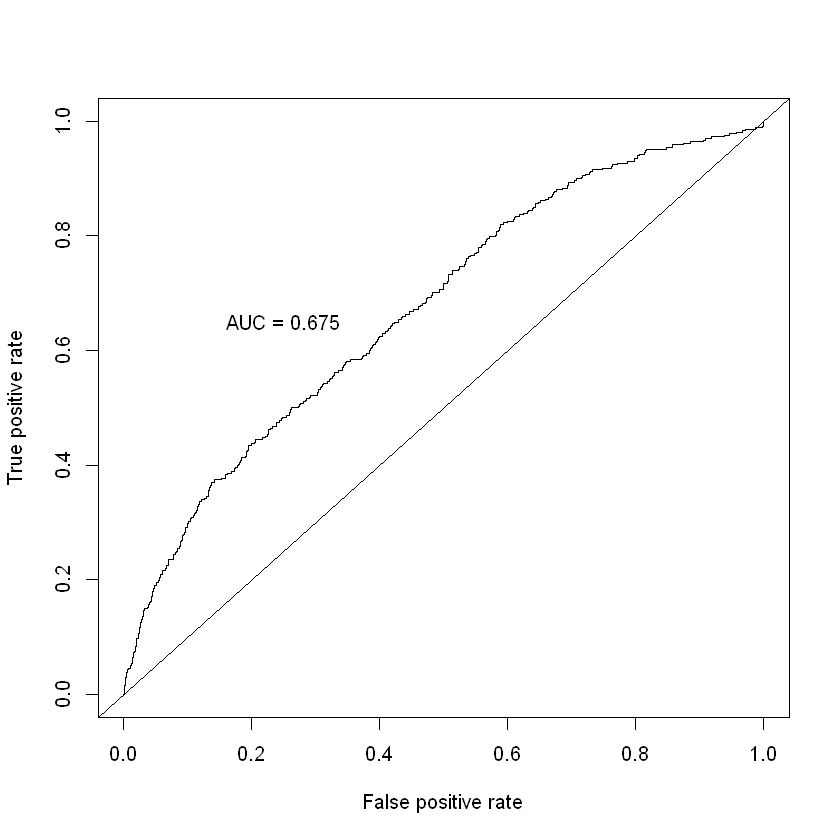

In [223]:
roc = performance(pred, measure = "tpr", x.measure = "fpr")
auc.test <- performance(pred, measure = "auc")
auc.test <- auc.test@y.values


plot(roc)
abline(a=0, b= 1)
text(x = .25, y = .65 ,paste("AUC = ", round(auc.test[[1]],3), sep = ""))

In [121]:
probabilities <- predict(lda.fit, reduced_validation_set, type = "response")

In [122]:
probs <- probabilities$posterior

In [123]:
nrow(probs )

[1] 10000

In [124]:
table_LDA <- cbind(reduced_validation_set,probs)

In [125]:
table_LDA <- table_LDA %>% dplyr::select(cust_id, yes)

In [126]:
write.csv(table_LDA , "C:/Users/rsmadja/Desktop/Master Big Data/S2/Statistical and ML techniques/Individual Project/mbd2020-sml-customer-churn-prediction/predictions5.csv")

## The model who performs the best is the Gradient Boosting